# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [12]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [13]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [14]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")
file_path_2 = Path("Data/neighborhoods_coordinates.csv")
neighborhood_data_2 = pd.read_csv(file_path_2, index_col="Neighborhood")

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [40]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    mean_per_year = sfo_data.groupby("year").mean()
    chart_0 = mean_per_year["housing_units"].plot(
        xlabel = "Year",
        ylabel = "Housing Units",
        title = "Housing Units in San Francisco from 2010 to 2016",
        kind = "bar")
    return chart_0

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    mean_cost_per_year = sfo_data.groupby("year").mean()
    df_2 = mean_cost_per_year[["sale_price_sqr_foot", "gross_rent"]]
    chart_1 = df_2["sale_price_sqr_foot"].hvplot.line(
        xlabel="Year", 
        ylabel="Price per SqFt", 
        title = "Average Price per SqFt by Year")
    return chart_1

def average_sales_price():
    """Average Sales Price Per Year."""
    
    mean_cost_per_year = sfo_data.groupby("year").mean()
    df_2 = mean_cost_per_year[["sale_price_sqr_foot", "gross_rent"]]
    chart_2 = df_2["gross_rent"].hvplot.line(
        xlabel="Year", 
        ylabel="Price per SqFt", 
        title = "Average Gross Rent by Year")
    return chart_2

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    mean_cost_per_year_and_neighborhood = sfo_data.groupby(["year", "neighborhood"]).mean()
    df_3 = mean_cost_per_year_and_neighborhood
    chart_3 = df_3.hvplot(
        x="year", 
        y="sale_price_sqr_foot", 
        groupby = "neighborhood", 
        kind = "line" )
    return chart_3

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    mean_per_year_per_neighborhood = sfo_data.groupby("neighborhood").mean()
    mean_per_year_per_neighborhood=mean_per_year_per_neighborhood.sort_values(by = ["sale_price_sqr_foot"], ascending = False)
    chart_4 = mean_per_year_per_neighborhood["sale_price_sqr_foot"].iloc[0:10].hvplot(
        kind="bar", 
        rot = 90, 
        xlabel="Neighborhood", 
        ylabel="Avg. Sale Price Per Square Foot", 
        title = "Top 10 Expensive Neighborhoods in SFO", 
        width = 1000)
    return chart_4

def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    
    mean_cost_per_year_and_neighborhood = sfo_data.groupby(["year", "neighborhood"]).mean()
    df_3 = mean_cost_per_year_and_neighborhood
    df_3.drop('housing_units', axis = 1, inplace=True)
    chart_5 = df_3.hvplot("year", 
                kind="bar", 
                rot = 90, 
                xlabel="Neighborhood", 
                ylabel="Avg. Sale Price Per Square Foot", 
                title = "Top 10 Expensive Neighborhoods in SFO", 
                width = 1000, 
                groupby = "neighborhood")
    return chart_5
    
def neighborhood_map():
    """Neighborhood Map."""

    mean_values = sfo_data.groupby("neighborhood").mean()
    joined = pd.concat([neighborhood_data_2, mean_values], axis = 1, join = "inner")
    load_dotenv()
    map_box_api = os.getenv("mapbox")
    px.set_mapbox_access_token(map_box_api)
    chart_6 = map_plot = px.scatter_mapbox(
        joined,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        title = "Average Sale Price Per Square Foot and Gross Rent in San Francisco",
        zoom=4
)
    return chart_6

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

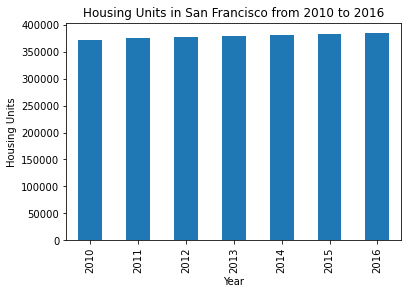

In [47]:
# Create a Title for the Dashboard
heading = "Real Estate Analysis of San Francisco from 2010 to 2016"
summary = "This dashboard shows visual analysis of historical prices in the San Francisco Area. The data ranges from 2010 to 2016. The first tab here shows a map to better visualize by location, and the following two tabs show analysis by year and neighborhood."
# Create a tab layout for the dashboard
first_tab = pn.Column(f'#{heading}', f'{summary}', neighborhood_map())
second_tab = pn.Column(f'##{heading}', housing_units_per_year(),average_gross_rent(), average_sales_price())
third_tab = pn.Column(f'##{heading}', average_price_by_neighborhood(), top_most_expensive_neighborhoods(), most_expensive_neighborhoods_rent_sales())

# Create the dashboard
dashboard = pn.Tabs(
    ("Welcome", first_tab), ("Yearly Market Analysis", second_tab), ("Neighborhood Analysis", third_tab)
)

## Serve the Panel Dashboard

In [48]:
# Serve the# dashboard
dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Plotly(Figure)
    [1] Column
        [0] Markdown(str)
        [1] Str(AxesSubplot)
        [2] HoloViews(Curve)
        [3] HoloViews(Curve)
    [2] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [2] HoloViews(Bars)
        [3] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()